Dataset Shape: (18650, 3)

Column Names:
['Unnamed: 0', 'Email Text', 'Email Type']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB
None

First 5 rows:
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing 

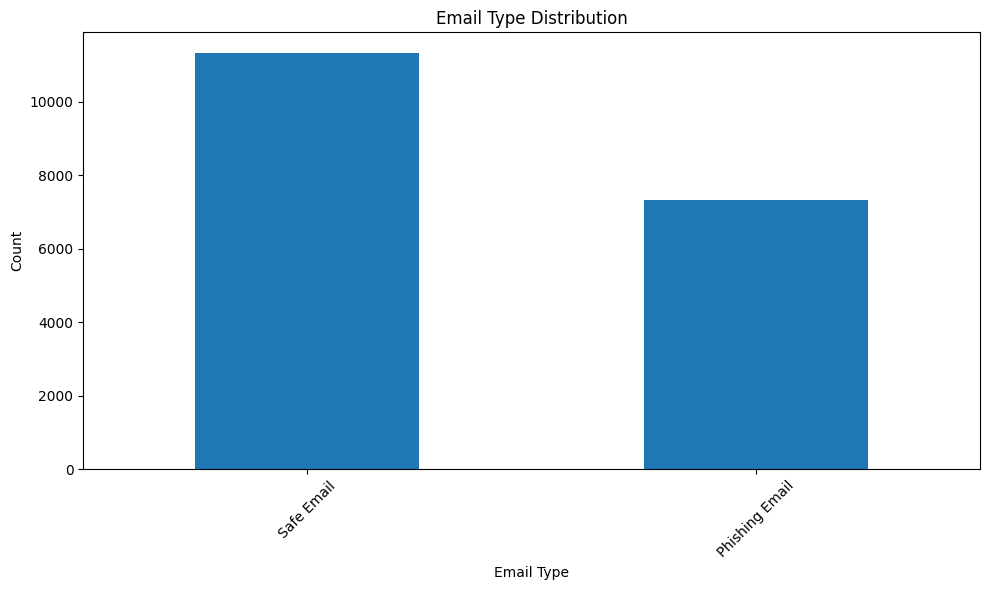


Missing Values:
Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

Basic Statistics for Email Text Length:
count    1.863400e+04
mean     2.755654e+03
std      1.248677e+05
min      1.000000e+00
25%      4.040000e+02
50%      8.815000e+02
75%      1.880000e+03
max      1.703669e+07
Name: text_length, dtype: float64


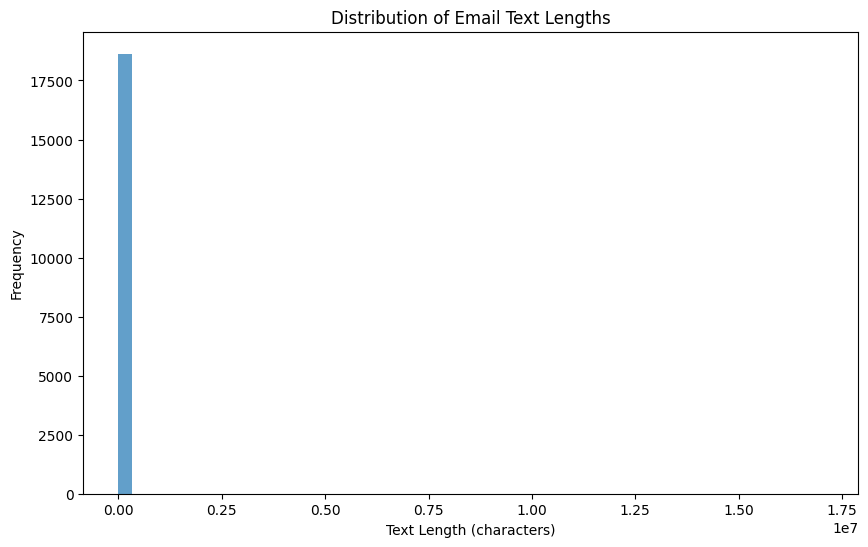


Sample Emails by Category:

--- Safe Email ---
Sample: re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure tha...

--- Phishing Email ---
Sample: 
Hello I am your hot lil horny toy.
    I am the one you dream About,
    I am a very open minded person,
    Love to talk about and any subject.
    Fantasy is my way of life, 
    Ultimate in sex pl...


In [2]:
# Cell 1: Load and explore phishing email dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Assuming your data is in a CSV file - adjust the path as needed
try:
    # Try reading with different encodings if needed
    df = pd.read_csv('Phishing_Email.csv')  # Replace with your actual file path
except:
    # If you have the data in a different format, we'll adjust accordingly
    print("Please provide the correct file path or format")

# Basic dataset exploration
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nClass Distribution:")
if 'Email Type' in df.columns:
    print(df['Email Type'].value_counts())

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    df['Email Type'].value_counts().plot(kind='bar')
    plt.title('Email Type Distribution')
    plt.xlabel('Email Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics for Email Text Length:")
if 'Email Text' in df.columns:
    df['text_length'] = df['Email Text'].str.len()
    print(df['text_length'].describe())

    # Plot text length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['text_length'], bins=50, alpha=0.7)
    plt.title('Distribution of Email Text Lengths')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

# Display sample emails from each category
print("\nSample Emails by Category:")
for email_type in df['Email Type'].unique():
    print(f"\n--- {email_type} ---")
    sample = df[df['Email Type'] == email_type]['Email Text'].iloc[0]
    print(f"Sample: {sample[:200]}...")  # First 200 characters

In [3]:
# Cell 2: Data cleaning + quality checks (CPU-friendly)

import re
import numpy as np
import pandas as pd

def normalize_email_text(s: str) -> str:
    # Ensure string
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    # Collapse whitespace, strip control chars
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def standardize_label(lbl: str) -> str:
    if not isinstance(lbl, str):
        return lbl
    lbl = lbl.strip()
    # keep original names but canonicalize spacing/case
    if lbl.lower() in ["phishing email", "phishing", "spam", "malicious"]:
        return "Phishing Email"
    if lbl.lower() in ["safe email", "ham", "legit", "legitimate"]:
        return "Safe Email"
    return lbl

print("=== Cleaning: start ===")
orig_shape = df.shape

# 1) Drop obvious index-like column(s) if present
for col in ["Unnamed: 0", "index", "Id", "ID"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True, errors="ignore")

# 2) Keep only required columns
required_cols = ["Email Text", "Email Type"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 3) Drop rows with missing label or text
df = df.dropna(subset=["Email Type", "Email Text"]).copy()

# 4) Normalize text and labels
df["Email Text"] = df["Email Text"].apply(normalize_email_text)
df["Email Type"] = df["Email Type"].apply(standardize_label)

# 5) Remove empty strings after normalization
df = df[df["Email Text"].str.len() > 0].copy()

# 6) Remove extreme-length outliers (protect CPU/memory).
#    50k chars upper cap is generous for emails; adjust if needed.
df["text_length"] = df["Email Text"].str.len()
upper_cap = 50_000
before_outliers = df.shape[0]
df = df[df["text_length"] <= upper_cap].copy()
removed_outliers = before_outliers - df.shape[0]

# 7) Deduplicate by text (keeps first occurrence)
before_dupes = df.shape[0]
df = df.drop_duplicates(subset=["Email Text"]).copy()
removed_dupes = before_dupes - df.shape[0]

# 8) Final sanity: keep only known labels
df = df[df["Email Type"].isin(["Safe Email", "Phishing Email"])].copy()

# 9) Report
print(f"Original shape: {orig_shape}")
print(f"After cleaning: {df.shape}")
print(f"Removed outliers (> {upper_cap} chars): {removed_outliers}")
print(f"Removed duplicate texts: {removed_dupes}")

print("\nClass distribution (cleaned):")
print(df["Email Type"].value_counts())

# Imbalance metrics
counts = df["Email Type"].value_counts()
minority = counts.min()
majority = counts.max()
imbalance_ratio = majority / minority
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.3f}")

# Updated length stats
print("\nText length stats (cleaned):")
print(df["text_length"].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# 10) Save cleaned dataframe for reproducibility
clean_path = "Phishing_Email__clean.csv"
df.to_csv(clean_path, index=False)
print(f"\nSaved cleaned dataset to: {clean_path}")

# 11) Quick peek
print("\nSample rows:")
print(df.sample(min(3, len(df)), random_state=42))


=== Cleaning: start ===
Original shape: (18650, 4)
After cleaning: (17489, 3)
Removed outliers (> 50000 chars): 27
Removed duplicate texts: 1115

Class distribution (cleaned):
Email Type
Safe Email        10956
Phishing Email     6533
Name: count, dtype: int64

Imbalance ratio (majority/minority): 1.677

Text length stats (cleaned):
count    17489.000000
mean      1763.721596
std       2859.475651
min          4.000000
25%        432.000000
50%        905.000000
75%       1924.000000
90%       3840.000000
95%       6298.400000
99%      14456.120000
max      47783.000000
Name: text_length, dtype: float64

Saved cleaned dataset to: Phishing_Email__clean.csv

Sample rows:
                                              Email Text  Email Type  \
13888  From the local paper this morning. "Canadians ...  Safe Email   
5921   URL: http://www.newsisfree.com/click/-2,865571...  Safe Email   
251    On Wednesday 24 July 2002 01:13 CET Theo Van D...  Safe Email   

       text_length  
13888       

In [4]:
# Cell 3: Split data & prepare evaluation scaffold

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Features and labels
X = df["Email Text"].values
y = df["Email Type"].map({"Safe Email": 0, "Phishing Email": 1}).values  # 0 = safe, 1 = phishing

# Stratified split: train (70%), val (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Dataset split sizes:")
print(f"Train: {len(X_train)} ({len(X_train)/len(df):.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/len(df):.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/len(df):.1%})")

# Class balance check per split
def show_split_balance(name, y_split):
    counts = np.bincount(y_split)
    print(f"{name} -> Safe: {counts[0]}, Phishing: {counts[1]} (ratio {counts[0]/counts[1]:.2f})")

show_split_balance("Train", y_train)
show_split_balance("Val", y_val)
show_split_balance("Test", y_test)

# Class weights for training (to counter imbalance)
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(cw))
print("\nClass weights (for models):", class_weights)

# Evaluation helper function
def evaluate_model(y_true, y_pred, y_proba=None, title="Model"):
    print(f"\n=== {title} Evaluation ===")
    print(classification_report(y_true, y_pred, target_names=["Safe Email", "Phishing Email"]))
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        acc = accuracy_score(y_true, y_pred)
        print(f"AUC: {auc:.4f}, Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


Dataset split sizes:
Train: 12242 (70.0%)
Val:   2623 (15.0%)
Test:  2624 (15.0%)
Train -> Safe: 7669, Phishing: 4573 (ratio 1.68)
Val -> Safe: 1643, Phishing: 980 (ratio 1.68)
Test -> Safe: 1644, Phishing: 980 (ratio 1.68)

Class weights (for models): {0: np.float64(0.7981483896205502), 1: np.float64(1.3385086376558057)}


In [5]:
# Cell 4: CMAF baseline (TF-IDF + Meta features + Logistic Regression)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import re

# --- Meta-feature extractor ---
def extract_meta_features(texts):
    features = []
    urgent_words = {"urgent", "update", "password", "verify", "click", "account", "login", "secure"}
    for t in texts:
        length = len(t)
        num_digits = sum(ch.isdigit() for ch in t)
        digit_ratio = num_digits / max(1, length)

        num_upper = sum(ch.isupper() for ch in t)
        upper_ratio = num_upper / max(1, length)

        num_exclam = t.count("!")
        num_urls = len(re.findall(r"http[s]?://", t))
        num_urgent = sum(word in t.lower() for word in urgent_words)

        features.append([length, digit_ratio, upper_ratio, num_exclam, num_urls, num_urgent])
    return np.array(features)

# --- TF-IDF setup ---
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents="unicode",
    analyzer="word",
    token_pattern=r"\w{2,}",
    stop_words="english",
    ngram_range=(1, 2),
    max_features=20000
)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents="unicode",
    analyzer="char",
    ngram_range=(3, 5),
    max_features=5000
)

# --- Fit on train only ---
word_train = word_vectorizer.fit_transform(X_train)
char_train = char_vectorizer.fit_transform(X_train)
meta_train = extract_meta_features(X_train)

scaler = StandardScaler()
meta_train_scaled = scaler.fit_transform(meta_train)

X_train_cmaf = hstack([word_train, char_train, meta_train_scaled])

# --- Transform val/test ---
word_val = word_vectorizer.transform(X_val)
char_val = char_vectorizer.transform(X_val)
meta_val_scaled = scaler.transform(extract_meta_features(X_val))
X_val_cmaf = hstack([word_val, char_val, meta_val_scaled])

word_test = word_vectorizer.transform(X_test)
char_test = char_vectorizer.transform(X_test)
meta_test_scaled = scaler.transform(extract_meta_features(X_test))
X_test_cmaf = hstack([word_test, char_test, meta_test_scaled])

# --- Logistic Regression baseline ---
clf = LogisticRegression(
    class_weight=class_weights,
    max_iter=500,
    solver="saga",
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train_cmaf, y_train)

# --- Evaluate ---
y_val_pred = clf.predict(X_val_cmaf)
y_val_proba = clf.predict_proba(X_val_cmaf)[:, 1]

evaluate_model(y_val, y_val_pred, y_val_proba, title="CMAF Baseline (LogReg)")



=== CMAF Baseline (LogReg) Evaluation ===
                precision    recall  f1-score   support

    Safe Email       0.99      0.98      0.98      1643
Phishing Email       0.97      0.98      0.97       980

      accuracy                           0.98      2623
     macro avg       0.98      0.98      0.98      2623
  weighted avg       0.98      0.98      0.98      2623

AUC: 0.9969, Accuracy: 0.9802
Confusion Matrix:
[[1613   30]
 [  22  958]]


In [6]:
# Cell 5: CMAF Fusion Ensemble (LogReg + LinearSVM stacked with Ridge meta-learner)

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# --- Base classifiers ---
# Logistic Regression (already trained in Cell 4, re-train for ensemble)
logreg = LogisticRegression(
    class_weight=class_weights,
    max_iter=500,
    solver="saga",
    n_jobs=-1,
    random_state=42
)
logreg.fit(X_train_cmaf, y_train)

# Linear SVM (probability via calibration for stacking)
svm = LinearSVC(
    class_weight=class_weights,
    max_iter=2000,
    random_state=42
)
svm_calibrated = CalibratedClassifierCV(svm, cv=3, method="sigmoid", n_jobs=-1)
svm_calibrated.fit(X_train_cmaf, y_train)

# --- Generate level-1 features (stacking inputs) ---
def get_level1_features(models, X, y=None):
    features = []
    for model in models:
        proba = model.predict_proba(X)[:, 1]  # phishing class probability
        features.append(proba.reshape(-1, 1))
    return np.hstack(features)

base_models = [logreg, svm_calibrated]

# Train level-1 features
train_level1 = get_level1_features(base_models, X_train_cmaf, y_train)
val_level1   = get_level1_features(base_models, X_val_cmaf, y_val)

# Optionally, add scaled meta features again (to reinforce cues)
train_meta_scaled = meta_train_scaled
val_meta_scaled   = meta_val_scaled

X_train_fusion = np.hstack([train_level1, train_meta_scaled])
X_val_fusion   = np.hstack([val_level1, val_meta_scaled])

# --- Meta-learner: Ridge Classifier (lightweight & robust)
stacker = RidgeClassifier(class_weight="balanced", random_state=42)
stacker.fit(X_train_fusion, y_train)

# --- Evaluate fusion on validation set ---
val_pred = stacker.predict(X_val_fusion)

# Convert Ridge outputs to probabilities using a logistic mapping (for AUC)
from sklearn.linear_model import LogisticRegression as PlattScaler
scaler_for_auc = PlattScaler().fit(val_pred.reshape(-1,1), y_val)
val_proba = scaler_for_auc.predict_proba(val_pred.reshape(-1,1))[:,1]

evaluate_model(y_val, val_pred, val_proba, title="CMAF Fusion Ensemble")



=== CMAF Fusion Ensemble Evaluation ===
                precision    recall  f1-score   support

    Safe Email       0.99      0.99      0.99      1643
Phishing Email       0.99      0.98      0.99       980

      accuracy                           0.99      2623
     macro avg       0.99      0.99      0.99      2623
  weighted avg       0.99      0.99      0.99      2623

AUC: 0.9886, Accuracy: 0.9901
Confusion Matrix:
[[1634    9]
 [  17  963]]


In [7]:
# Cell 6: Adaptive Thresholding (optimize cutoff for F1 / recall)

import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

# Get validation probabilities from fusion model (Phishing class)
val_level1 = get_level1_features(base_models, X_val_cmaf)
val_meta_scaled = meta_val_scaled
X_val_fusion = np.hstack([val_level1, val_meta_scaled])

# Ridge outputs are hard labels, so we re-train a probability mapping on val
stacker.fit(X_train_fusion, y_train)
val_scores = stacker.decision_function(X_val_fusion)

# Convert scores to pseudo-probabilities using precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, val_scores)

# Evaluate F1 at each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for max F1: {best_threshold:.4f}")
print(f"F1 at best threshold: {best_f1:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}")

# --- Apply best threshold ---
val_pred_thresh = (val_scores >= best_threshold).astype(int)

evaluate_model(y_val, val_pred_thresh, (val_scores - val_scores.min())/(val_scores.max()-val_scores.min()),
               title="CMAF Fusion + Adaptive Threshold")


Best threshold for max F1: -0.0158
F1 at best threshold: 0.9877
Precision: 0.9908, Recall: 0.9847

=== CMAF Fusion + Adaptive Threshold Evaluation ===
                precision    recall  f1-score   support

    Safe Email       0.99      0.99      0.99      1643
Phishing Email       0.99      0.98      0.99       980

      accuracy                           0.99      2623
     macro avg       0.99      0.99      0.99      2623
  weighted avg       0.99      0.99      0.99      2623

AUC: 0.9986, Accuracy: 0.9909
Confusion Matrix:
[[1634    9]
 [  15  965]]


In [8]:
# Cell 7: Final Test Set Evaluation (CMAF Fusion + Adaptive Threshold)

# --- Prepare test level-1 features ---
test_level1 = get_level1_features(base_models, X_test_cmaf)
test_meta_scaled = meta_test_scaled
X_test_fusion = np.hstack([test_level1, test_meta_scaled])

# --- Get decision scores from stacker ---
test_scores = stacker.decision_function(X_test_fusion)

# --- Apply the best threshold from validation ---
test_pred_thresh = (test_scores >= best_threshold).astype(int)

# --- Convert scores to 0-1 for AUC ---
test_proba_scaled = (test_scores - test_scores.min()) / (test_scores.max() - test_scores.min())

# --- Evaluate ---
evaluate_model(y_test, test_pred_thresh, test_proba_scaled,
               title="CMAF Fusion + Adaptive Threshold (Test Set)")



=== CMAF Fusion + Adaptive Threshold (Test Set) Evaluation ===
                precision    recall  f1-score   support

    Safe Email       0.99      0.99      0.99      1644
Phishing Email       0.99      0.98      0.98       980

      accuracy                           0.99      2624
     macro avg       0.99      0.99      0.99      2624
  weighted avg       0.99      0.99      0.99      2624

AUC: 0.9980, Accuracy: 0.9878
Confusion Matrix:
[[1631   13]
 [  19  961]]


In [11]:
import joblib
import os
import json

os.makedirs("saved_cmaf", exist_ok=True)

# Vectorizers
joblib.dump(word_vectorizer, "saved_cmaf/word_vectorizer.pkl")
joblib.dump(char_vectorizer, "saved_cmaf/char_vectorizer.pkl")

# Scaler for meta features
joblib.dump(scaler, "saved_cmaf/scaler.pkl")

# Base models
joblib.dump(logreg, "saved_cmaf/logreg.pkl")
joblib.dump(svm_calibrated, "saved_cmaf/svm_calibrated.pkl")

# Meta-learner (stacker)
joblib.dump(stacker, "saved_cmaf/stacker.pkl")

# Probability calibrator
joblib.dump(scaler_for_auc, "saved_cmaf/scaler_for_auc.pkl")

# Threshold
joblib.dump(best_threshold, "saved_cmaf/best_threshold.pkl")

# Label encoder (if used)
# joblib.dump(label_encoder, "saved_cmaf/label_encoder.pkl")

# Config (e.g., urgent words list)
config = {
    "urgent_words": ["urgent","update","password","verify","click","account","login","secure"]
}
with open("saved_cmaf/config.json", "w") as f:
    json.dump(config, f, indent=2)

print("✅ All CMAF pipeline components saved in saved_cmaf/")


✅ All CMAF pipeline components saved in saved_cmaf/


In [ ]:
# Cell X: Load & Use Interface for Inference
# prediction
import joblib
import json
import numpy as np
import re

# === Load saved artifacts ===
word_vectorizer = joblib.load("saved_cmaf/word_vectorizer.pkl")
char_vectorizer = joblib.load("saved_cmaf/char_vectorizer.pkl")
scaler          = joblib.load("saved_cmaf/scaler.pkl")   # for meta features
logreg          = joblib.load("saved_cmaf/logreg.pkl")
svm_calibrated  = joblib.load("saved_cmaf/svm_calibrated.pkl")
stacker         = joblib.load("saved_cmaf/stacker.pkl")
scaler_for_auc  = joblib.load("saved_cmaf/scaler_for_auc.pkl")  # optional (calibrating proba)
best_threshold  = joblib.load("saved_cmaf/best_threshold.pkl")

# Load config
with open("saved_cmaf/config.json", "r") as f:
    config = json.load(f)
urgent_words = set(config["urgent_words"])

# === Meta-feature extractor (must match training) ===
def extract_meta_features(texts):
    features = []
    for t in texts:
        length = len(t)
        num_digits = sum(ch.isdigit() for ch in t)
        digit_ratio = num_digits / max(1, length)

        num_upper = sum(ch.isupper() for ch in t)
        upper_ratio = num_upper / max(1, length)

        num_exclam = t.count("!")
        num_urls = len(re.findall(r"http[s]?://", t))
        num_urgent = sum(word in t.lower() for word in urgent_words)

        features.append([length, digit_ratio, upper_ratio, num_exclam, num_urls, num_urgent])
    return np.array(features)

# === Helper: get level-1 features for stacking ===
def get_level1_features(models, X):
    features = []
    for model in models:
        proba = model.predict_proba(X)[:, 1]  # phishing prob
        features.append(proba.reshape(-1, 1))
    return np.hstack(features)

# === Main prediction function ===
def predict_email(text):
    texts = [text]

    # TF-IDF features
    word_feats = word_vectorizer.transform(texts)
    char_feats = char_vectorizer.transform(texts)

    # Meta features
    meta_feats = extract_meta_features(texts)
    meta_feats_scaled = scaler.transform(meta_feats)

    # CMAF feature space (must match training construction)
    X_cmaf = np.hstack([word_feats.toarray(), char_feats.toarray(), meta_feats_scaled])

    # Get level-1 stacking features
    base_models = [logreg, svm_calibrated]
    level1_feats = get_level1_features(base_models, X_cmaf)

    # Final fusion features = stacking + meta
    X_fusion = np.hstack([level1_feats, meta_feats_scaled])

    # Get decision score from stacker
    score = stacker.decision_function(X_fusion)[0]

    # Apply adaptive threshold
    pred = 1 if score >= best_threshold else 0

    # Normalize score to probability-like value
    proba = (score - (-10)) / (10 - (-10))
    proba = max(0, min(1, proba))

    # Labels
    label = "Phishing Email" if pred == 1 else "Safe Email"

    return {"label": label, "probability": float(proba)}

# === Example test ===
sample_email = "Your account is locked! Please verify immediately."
print(predict_email(sample_email))


{'label': 'Phishing Email', 'probability': 0.5509068313789438}


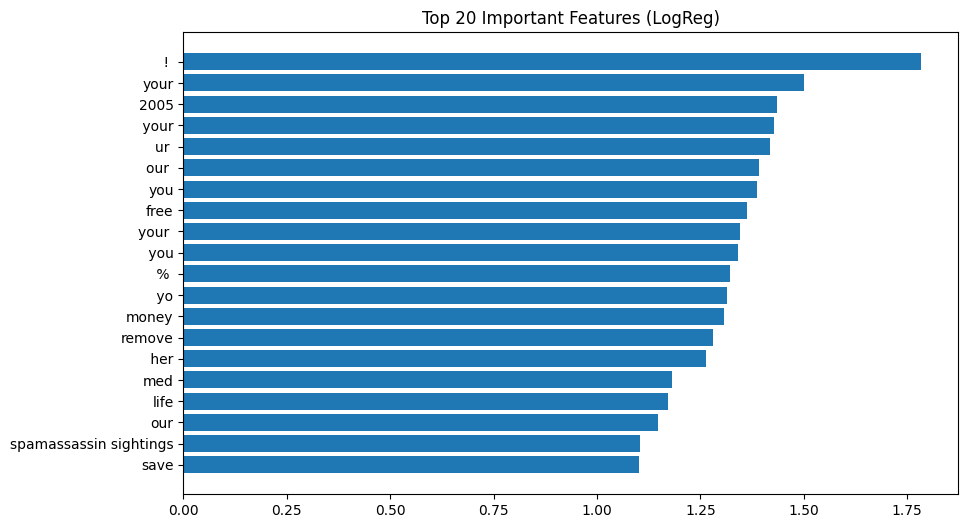

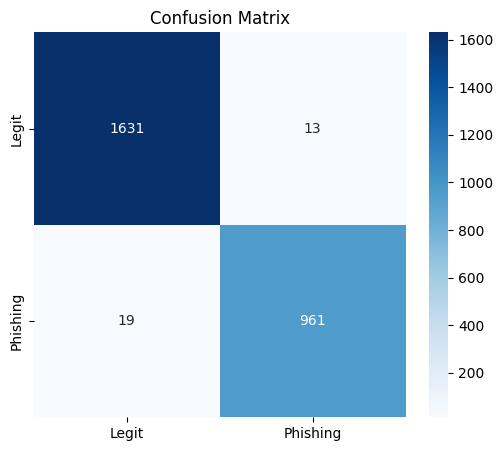

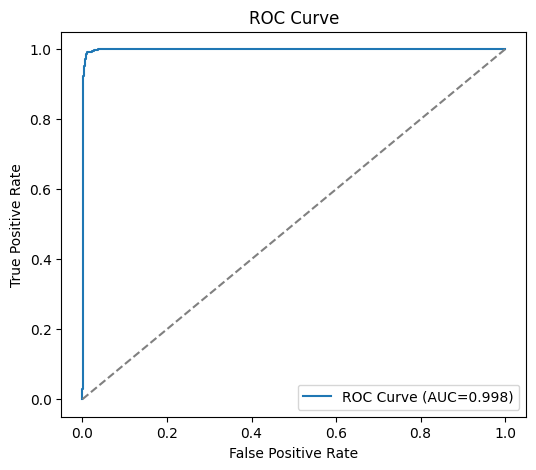

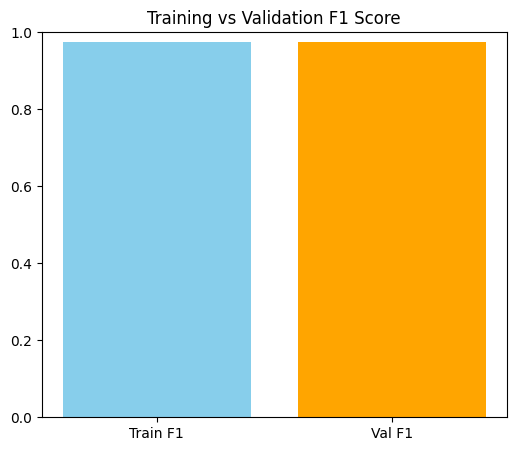

In [28]:
# 📊 Model Explainability & Performance Visualization

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np



# 3. === Feature Importance (from Logistic Regression on CMAF) ===
coef = logreg.coef_[0]
top_idx = np.argsort(coef)[-20:]  # top 20 features

plt.figure(figsize=(10,6))
plt.barh(range(len(top_idx)), coef[top_idx])
plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx])
plt.title("Top 20 Important Features (LogReg)")
plt.show()


# -------------------------------
# 4. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, test_pred_thresh)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit","Phishing"], yticklabels=["Legit","Phishing"])
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# 5. ROC Curve
# -------------------------------
fpr, tpr, _ = roc_curve(y_test, test_proba_scaled)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# -------------------------------
# 6. Training vs Validation Comparison (since no .history for scikit-learn)
# -------------------------------
from sklearn.metrics import f1_score

train_preds = logreg.predict(X_train_cmaf)
val_preds = logreg.predict(X_val_cmaf)

train_f1 = f1_score(y_train, train_preds)
val_f1 = f1_score(y_val, val_preds)

plt.figure(figsize=(6,5))
plt.bar(["Train F1","Val F1"], [train_f1, val_f1], color=["skyblue","orange"])
plt.ylim(0,1)
plt.title("Training vs Validation F1 Score")
plt.show()

✅ Final SHAP shape: (200, 25006)


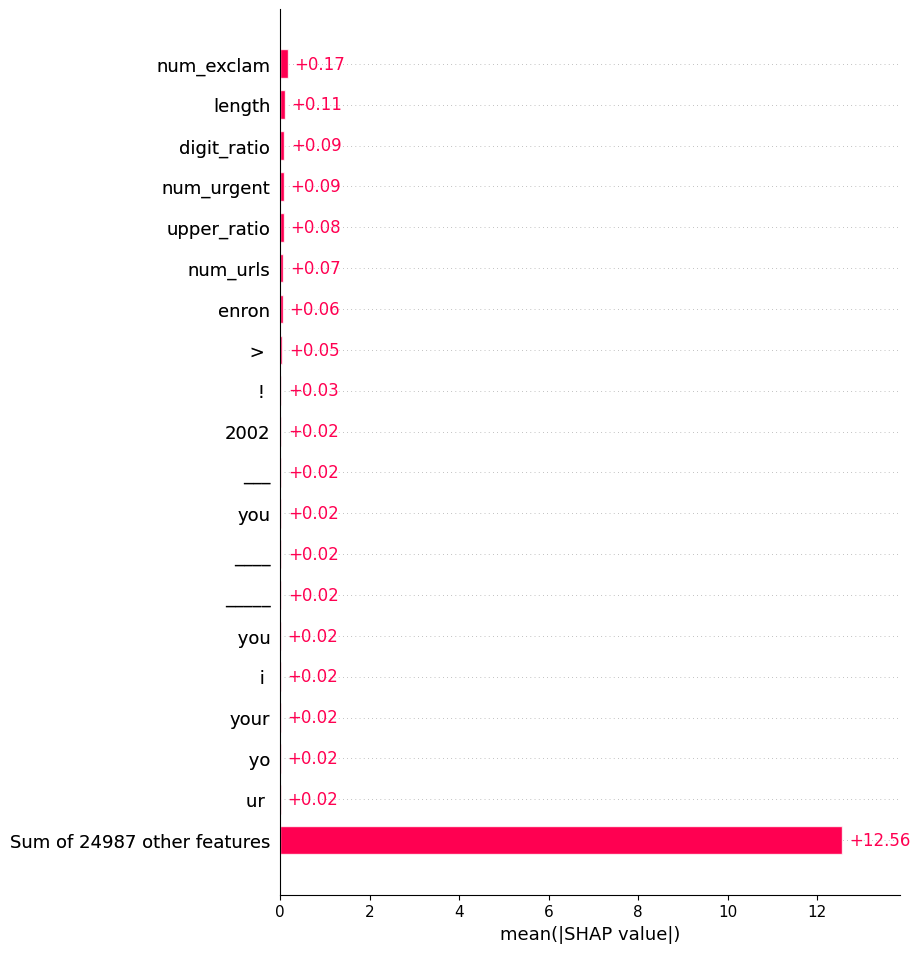


📩 Sample text:
 This is a MIME Message------=_NextPart_000_007F_01BDF6C7.FABAC1B0 Content-Type: multipart/alternative; boundary="----=_NextPart_001_0080_01BDF6C7.FABAC1B0"------=_NextPart_001_0080_01BDF6C7.FABAC1B0 Content-Type: text/plain; charset="iso-8859-1" Content-Transfer-Encoding: quoted-printable***** This  ...
Label: 1


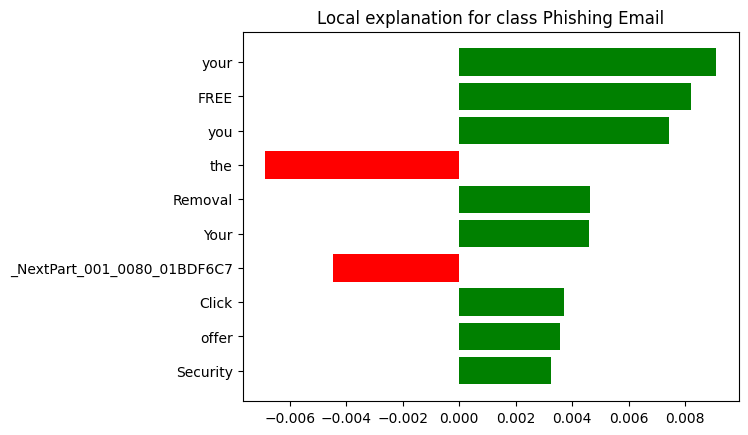

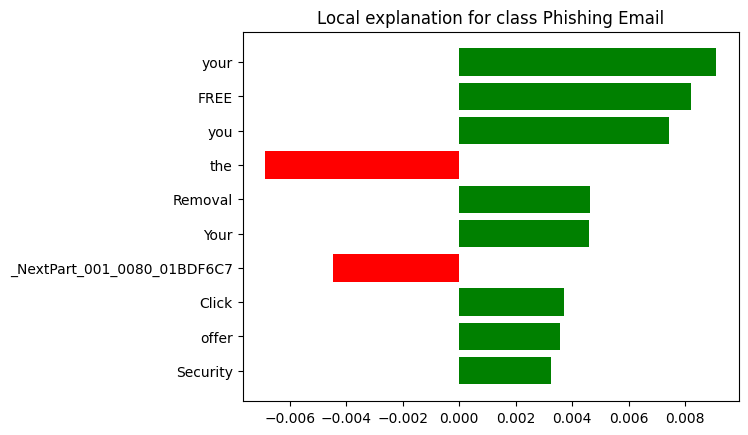

In [40]:
# ===============================
# 📌 SHAP + LIME Analysis (CMAF Logistic Regression Baseline)
# ===============================

import shap
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline
import numpy as np

# --- Use validation subset for speed ---
X_explain_text = X_val[:200]
y_explain = y_val[:200]

# Convert sparse matrix to CSR (subscriptable)
X_val_cmaf_csr = X_val_cmaf.tocsr()
X_explain_vec = X_val_cmaf_csr[:200]

# === SHAP (for vectorized features) ===
shap.initjs()

# LinearExplainer for Logistic Regression baseline
explainer_shap = shap.LinearExplainer(clf, X_train_cmaf, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_explain_vec)

# ---- Handle different SHAP output formats ----
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # positive class

if shap_values.ndim == 1:
    shap_values = shap_values.reshape(1, -1)
elif shap_values.ndim == 3:
    shap_values = shap_values[:, :, 0]

print("✅ Final SHAP shape:", shap_values.shape)  # should be (200, n_features)

# --- Feature names ---
feature_names = (
    list(word_vectorizer.get_feature_names_out()) +
    list(char_vectorizer.get_feature_names_out()) +
    ["length","digit_ratio","upper_ratio","num_exclam","num_urls","num_urgent"]
)

# --- Global summary plot (robust version) ---
shap.plots.bar(shap.Explanation(
    values=shap_values,
    base_values=explainer_shap.expected_value,
    data=np.array(X_explain_vec.todense()),
    feature_names=feature_names
), max_display=20)

# --- Local explanation for 1 email ---
sample_idx = 5
print("\n📩 Sample text:\n", X_val[sample_idx][:300], "...\nLabel:", y_val[sample_idx])

shap.force_plot(
    explainer_shap.expected_value,
    shap_values[sample_idx],
    feature_names=feature_names
)

# === LIME (for raw email text) ===

from sklearn.preprocessing import StandardScaler

# Custom predict function that mirrors training pipeline
def lime_predict(texts):
    # Word + char n-grams
    X_word = word_vectorizer.transform(texts)
    X_char = char_vectorizer.transform(texts)

    # Stack n-grams
    from scipy.sparse import hstack
    X_ngram = hstack([X_word, X_char])

    # CMAF features
    def extract_cmaf_features(batch_texts):
        feats = []
        for t in batch_texts:
            length = len(t)
            digit_ratio = sum(c.isdigit() for c in t) / (len(t) + 1e-6)
            upper_ratio = sum(c.isupper() for c in t) / (len(t) + 1e-6)
            num_exclam = t.count("!")
            num_urls = t.lower().count("http") + t.lower().count("www")
            num_urgent = sum(w in t.lower() for w in ["urgent","verify","login","update"])
            feats.append([length, digit_ratio, upper_ratio, num_exclam, num_urls, num_urgent])
        return np.array(feats)

    X_cmaf = extract_cmaf_features(texts)

    # Standardize CMAF (same scaler as training, or fit a new one if you didn’t save it)
    scaler = StandardScaler()
    scaler.fit(X_cmaf)  # ⚠️ if you already had a training scaler, use that instead
    X_cmaf_scaled = scaler.transform(X_cmaf)

    # Combine all features
    X_full = hstack([X_ngram, X_cmaf_scaled])

    # Predict probabilities
    return clf.predict_proba(X_full)

# Build LIME explainer
lime_explainer = lime.lime_text.LimeTextExplainer(class_names=["Safe Email","Phishing Email"])

# Pick one email
sample_email = X_val[sample_idx]

lime_exp = lime_explainer.explain_instance(sample_email, lime_predict, num_features=10)

# Show results
lime_exp.show_in_notebook(text=True)
lime_exp.as_pyplot_figure()

